## Stokes equations with stabilized first order elements ##

First, import the `fenics` module:

In [1]:
from dolfin import *

In this example, different boundary conditions are prescribed on
different parts of the boundaries. This information must be made
available to the solver. One way of doing this, is to tag the
different sub-regions with different (integer) labels. DOLFIN provides
a class `MeshFunction` which is useful for these types of operations: instances of this class
represent functions over mesh entities (such as over cells or over
facets). Mesh and mesh functions can be read from file in the
following way:

You can download the data files at
[dolfin_fine.xml.gz](https://bitbucket.org/fenics-project/dolfin/raw/master/demo/documented/stokes-taylor-hood/dolfin_fine.xml.gz)
and [dolfin_fine_subdomains.xml.gz](https://bitbucket.org/fenics-project/dolfin/raw/master/demo/documented/stokes-taylor-hood/dolfin_fine_subdomains.xml.gz)

In [2]:
# Load mesh and subdomains
mesh = Mesh("dolfin_fine.xml.gz")
sub_domains = MeshFunction("size_t", mesh, "dolfin_fine_subdomains.xml.gz")

Next, we define a `MixedFunctionSpace` composed of a
`VectorFunctionSpace` and a `FunctionSpace`, both of
continuous piecewise linears.

In [3]:
# Define function spaces
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 1)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = P2 * P1
W = FunctionSpace(mesh, TH)

Now that we have our mixed function space and marked subdomains
defining the boundaries, we create functions for the boundary
conditions and define boundary conditions:

In [4]:
# No-slip boundary condition for velocity
# x1 = 0, x1 = 1 and around the dolphin
noslip = Constant((0, 0))
inflow = Expression(("-sin(x[1]*pi)", "0.0"), degree=2)
zero   = Constant(0)

# No-slip boundary condition for velocity
bc0 = DirichletBC(W.sub(0), noslip, sub_domains, 0)

# Inflow boundary condition for velocity
bc1 = DirichletBC(W.sub(0), inflow, sub_domains, 1)

# Boundary condition for pressure at outflow
bc2 = DirichletBC(W.sub(1), zero, sub_domains, 2)

# Collect boundary conditions
bcs = [bc0, bc1, bc2]

Here, we have given four arguments to `DirichletBC`. The first specifies the `FunctionSpace`. Since
we have a `MixedFunctionSpace`, we write
system.sub(0) for the `VectorFunctionSpace`, and
system.sub(1) for the `FunctionSpace`. The second argument specifies
the value on the Dirichlet boundary. The two last arguments specify the
marking of the subdomains; sub_domains contains the subdomain markers
and the number given as the last argument is the subdomain index.

The bilinear and linear forms corresponding to the stabilized weak
mixed formulation of the Stokes equations are defined as follows:

In [5]:
# Define variational problem
(v, q) = TestFunctions(W)
(u, p) = TrialFunctions(W)
f = Constant((0, 0))
h = CellSize(mesh)
beta  = 0.2
delta = beta*h*h
a = (inner(grad(v), grad(u)) - div(v)*p + q*div(u) + \
    delta*inner(grad(q), grad(p)))*dx
L = inner(v + delta*grad(q), f)*dx

To compute the solution we use the bilinear and linear forms, and the
boundary condition, but we also need to create a `Function` 
to store the solution(s). The (full)
solution will be stored in ``w``, which we initialize using the
MixedFunctionSpace system. The actual computation is performed by
calling solve with the arguments ``a``, ``L`` and ``bcs``. The
separate components ``u`` and ``p`` of the solution can be extracted
by calling the `split` function.

In [6]:
# Compute solution
w = Function(W)
solve(a == L, w, bcs)
u, p = w.split()

Finally, we can store to file and plot the solutions.

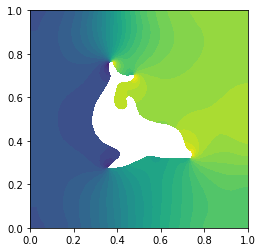

In [7]:
# Save solution in VTK format
ufile_pvd = File("velocity.pvd")
ufile_pvd << u
pfile_pvd = File("pressure.pvd")
pfile_pvd << p

%matplotlib inline
# Plot solution
plot(u)
plot(p)

**Acknowledgment**: This notebook was adapted from the [FEniCS/DOLFIN demo on Stokes equations with stabilized first order elements](https://fenicsproject.org/olddocs/dolfin/1.5.0/python/demo/documented/stokes-stabilized/python/documentation.html).